### 用Popularity做 OLS 模型

# 1 讀取資料

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
# 讀取 A1 與 A2 資料
high = pd.read_csv("spotify/data/high_popularity_spotify_data.csv")
low = pd.read_csv("spotify/data/low_popularity_spotify_data.csv")


df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')
df.head()

df['playlist_genre'].value_counts()
df['track_artist'].value_counts()


track_artist
Bad Bunny             30
Ren Avel              26
Asake                 21
Bnxn                  19
LoFi Waiter           18
                      ..
RADWIMPS, Toaka        1
結束バンド                  1
MAISONdes, 花譜, ツミキ     1
SPYAIR                 1
Sudha Ragunathan       1
Name: count, Length: 3390, dtype: int64

# 2 初步觀察

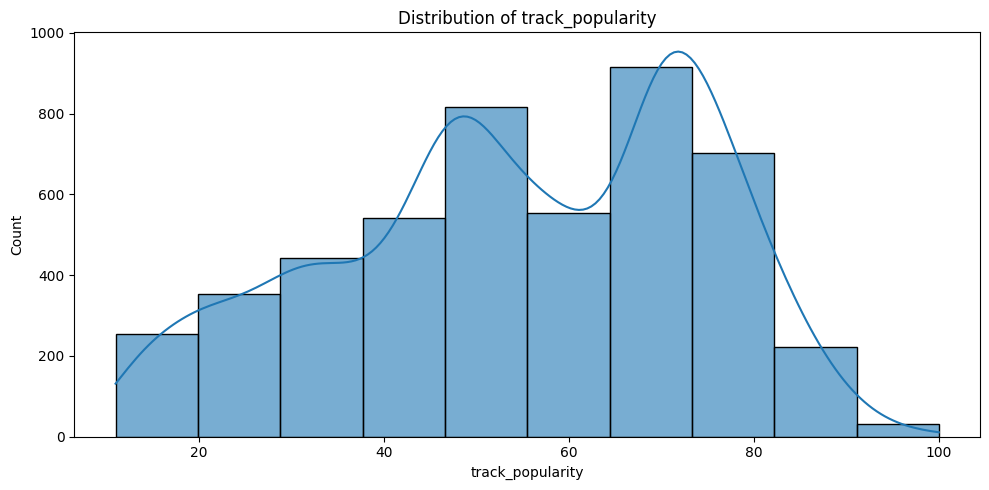

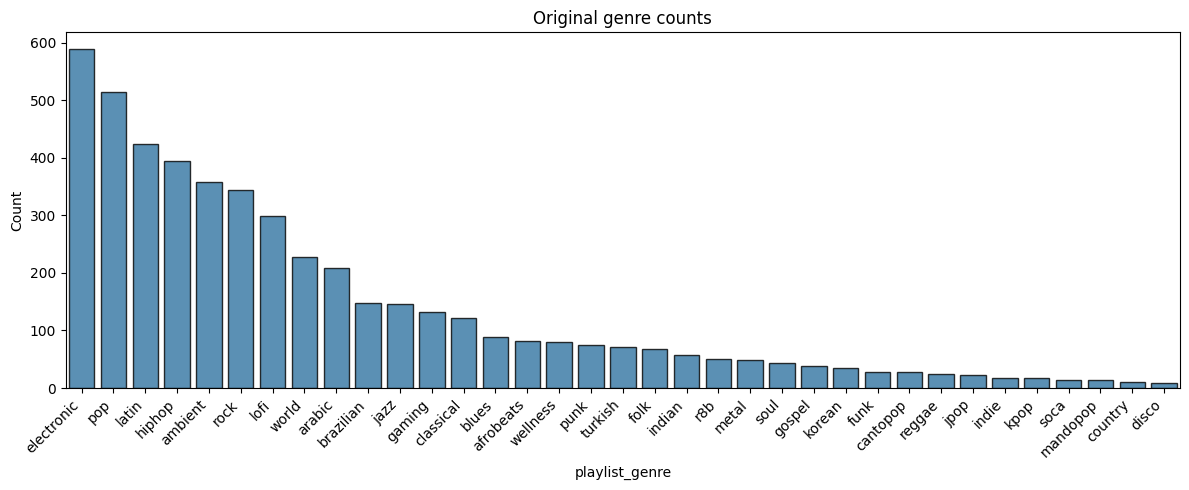

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# ── 第一欄：track_popularity 的Histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df,
    x="track_popularity",
    bins=10,          # 加大組數
    kde=True,         # 加上密度曲線
    stat="count",
    edgecolor="black",
    alpha=0.6
)
plt.title("Distribution of track_popularity")
plt.xlabel("track_popularity")
plt.ylabel("Count")
plt.tight_layout()


# ── 第二欄：原始 playlist_genre 的次數條形圖
genre_counts = df["playlist_genre"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(
    x=genre_counts.index,
    y=genre_counts.values,
    edgecolor="black",
    alpha=0.8
)
plt.title("Original genre counts")
plt.xlabel("playlist_genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()


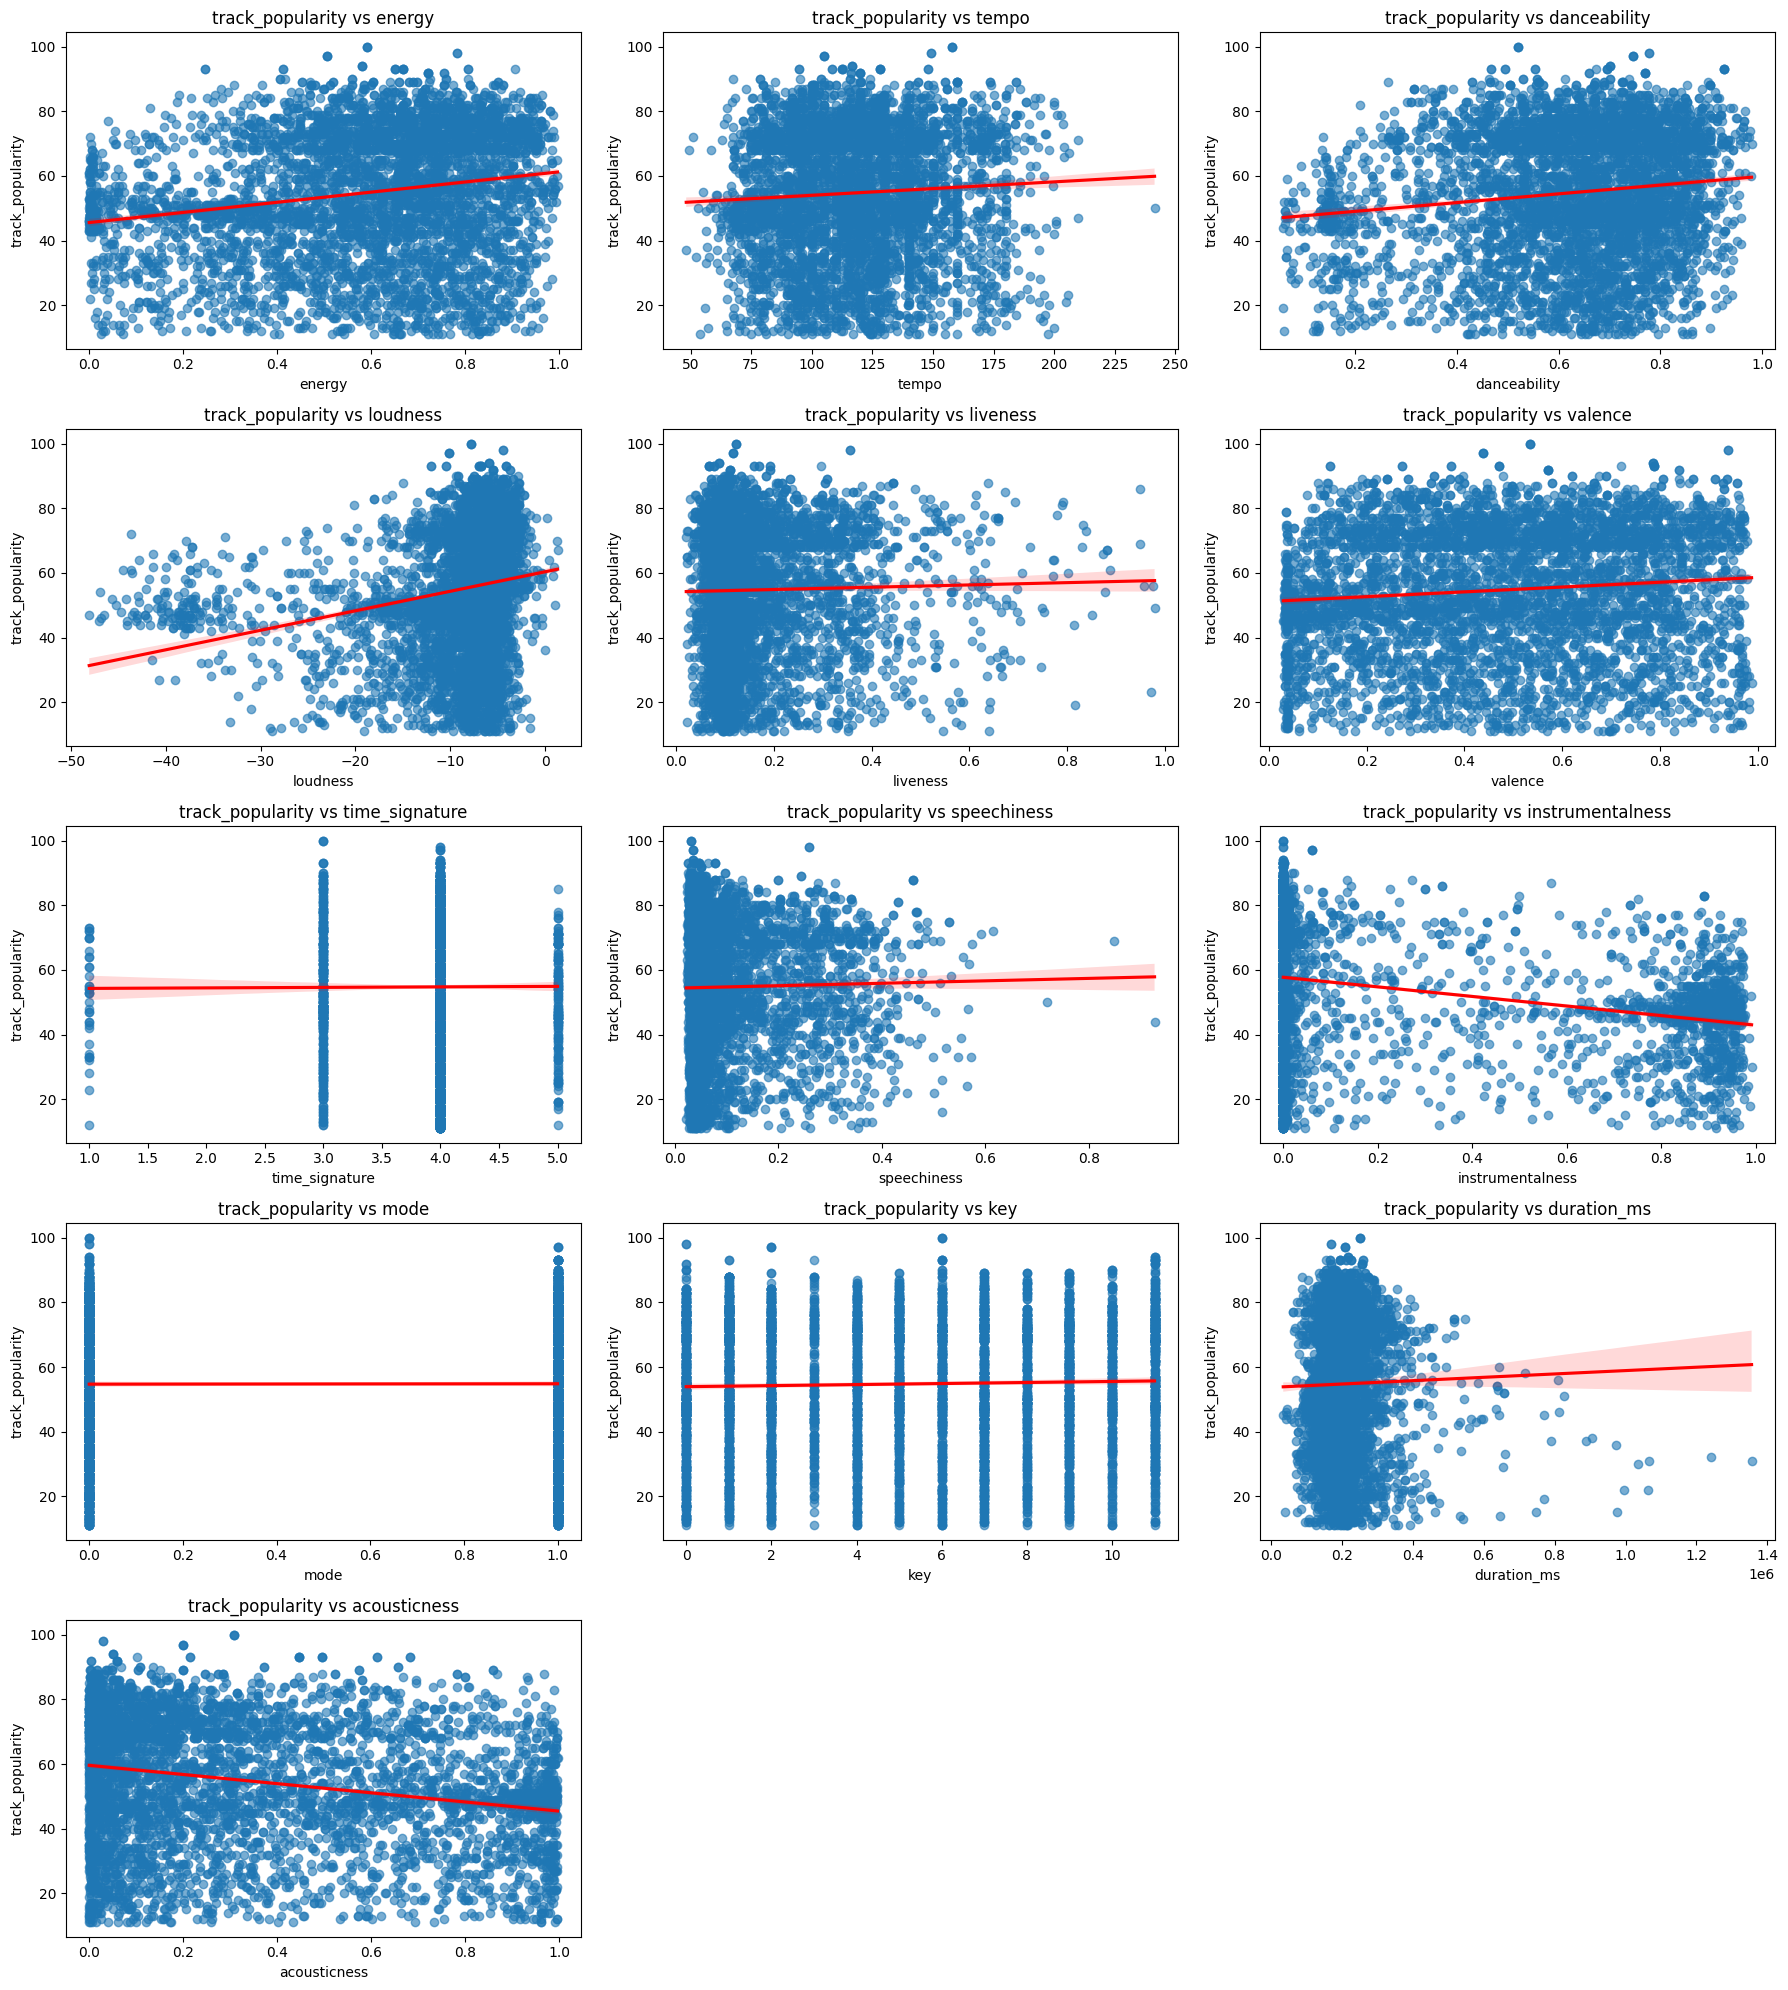

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 目標變數與自變數
response = "track_popularity"
predictors = df.select_dtypes(include="number").columns.tolist()
predictors.remove(response)

# 畫圖排版（每列最多 3 張圖）
n_cols = 3
n_rows = (len(predictors) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

for idx, var in enumerate(predictors):
    row = idx // n_cols
    col = idx % n_cols
    ax = axs[row][col] if n_rows > 1 else axs[col]

    sns.regplot(
        x=var, y=response, data=df,
        ax=ax,
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'red'}
    )
    ax.set_title(f"{response} vs {var}")
    ax.set_xlabel(var)
    ax.set_ylabel(response)

# 如果圖表數不是剛好填滿，把多出來的空圖清掉
total_plots = n_rows * n_cols
if total_plots > len(predictors):
    for idx in range(len(predictors), total_plots):
        fig.delaxes(axs[idx // n_cols][idx % n_cols])

plt.tight_layout()
plt.show()


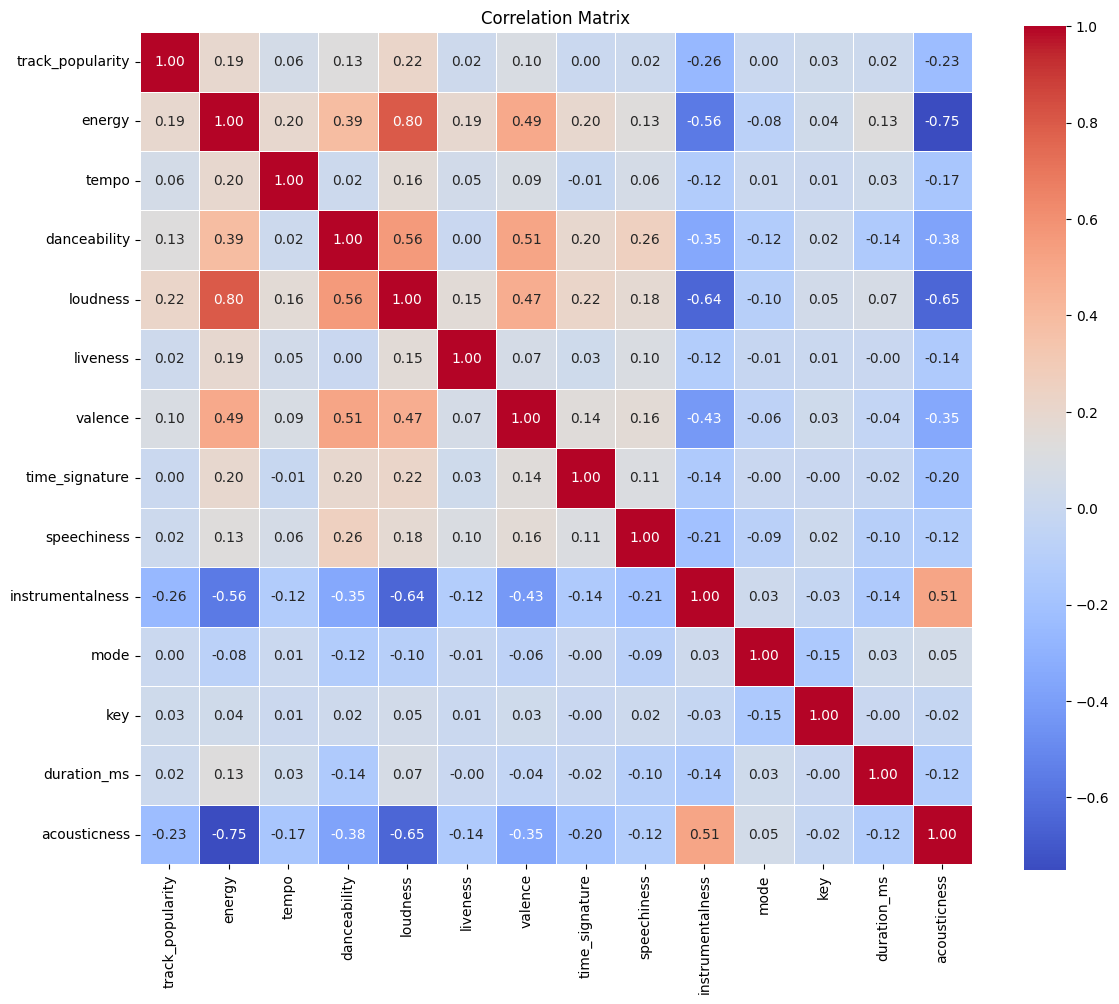

In [ ]:
# 2) Correlation Matrix (係數矩陣)
# 先組成只含數值欄位的 DataFrame
corr_vars = [response] + predictors
corr = df[corr_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,      # 在每個格子顯示數值
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 3 資料前處理

### 去除唯一（曲名、UID、播放清單名）欄位

In [5]:
drop_cols = ['track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'type', 'playlist_id', 'playlist_subgenre']

df_dropped = df.drop(columns=drop_cols)
df_dropped = df_dropped.dropna()

### 合併欄位

In [7]:
# 合併 rare genres 為 "其他"
threshold = 80  # 少於 50 則視為 rare
vc = df_dropped['playlist_genre'].value_counts()
rare = vc[vc < threshold].index
df_dropped['playlist_genre'] = df_dropped['playlist_genre'].replace(rare, 'other')
df_dropped['track_artist'] = df_dropped['track_artist'].str.split(',').str[0].str.strip()
df_dropped['playlist_genre'].value_counts()

playlist_genre
other         670
electronic    589
pop           515
latin         425
hiphop        395
ambient       359
rock          345
lofi          298
world         228
arabic        208
brazilian     148
jazz          146
gaming        133
classical     121
blues          88
afrobeats      82
wellness       80
Name: count, dtype: int64

### 設定虛擬變數

In [15]:

# 要轉換為 dummy 的欄位
dummy_columns = ["playlist_genre", "time_signature", "mode", "key"]
for col in ["time_signature", "mode", "key"]:
    if col in df_dropped.columns:
        df_dropped[col] = df_dropped[col].apply(lambda x: str(int(x)) if pd.notnull(x) else "unknown")
        
print(df_dropped[dummy_columns])

# 過濾出 df 中實際存在的欄位
available_columns = [col for col in dummy_columns if col in df_dropped.columns]

# ✅ prefix 也依照 available_columns 對齊
dummies = pd.get_dummies(df_dropped[available_columns], drop_first=True)

# 合併進原始資料（移除原類別欄位）
df_dummy = pd.concat([df_dropped.drop(columns=available_columns), dummies], axis=1)
print(df_dummy.shape)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_dummy.head())

df_dummy = df_dummy.reset_index(drop=True)
print(df_dummy['playlist_genre_electronic'].value_counts(normalize=True))


     playlist_genre time_signature mode key
0               pop              3    0   6
1               pop              4    1   2
2               pop              4    1   1
3               pop              4    0   0
4               pop              4    0   0
...             ...            ...  ...  ..
4826          other              1    1  10
4827          other              4    1   8
4828          other              4    1   3
4829          other              1    0   8
4830          other              4    1   8

[4830 rows x 4 columns]
(4830, 43)
   energy    tempo  danceability  loudness  liveness  valence  \
0   0.592  157.969         0.521    -7.777     0.122    0.535   
1   0.507  104.978         0.747   -10.171     0.117    0.438   
2   0.808  108.548         0.554    -4.169     0.159    0.372   
3   0.910  112.966         0.670    -4.070     0.304    0.786   
4   0.783  149.027         0.777    -4.477     0.355    0.939   

        track_artist  speechiness  track_popu

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# 假設 df 是你的資料
response = 'track_popularity'

# Step 1: 異常值偵測
def detect_outliers(df, response):
    predictors = df.columns.tolist()
    predictors.remove(response)
    formula = f"{response} ~ {' + '.join(predictors)}"
    model = smf.ols(formula=formula, data=df)
    result = model.fit()
    influence = result.get_influence()
    std_resid = influence.resid_studentized_internal
    leverage = influence.hat_matrix_diag
    cooks_d = influence.cooks_distance[0]
    outlier_df = pd.DataFrame({'std_resid': std_resid, 'leverage': leverage, 'cooks_d': cooks_d})
    outlier_flags = (
        (np.abs(outlier_df['std_resid']) > 3) |
        (outlier_df['leverage'] > 3 * np.mean(leverage)) |
        (outlier_df['cooks_d'] > 4 / len(df))
    )
    outlier_index = outlier_df[outlier_flags].index
    return outlier_index

# Step 2: Forward Selection
def forward_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')

    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data=data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]

        if best_new_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break
    return selected

# Step 3: Backward Elimination
def backward_elimination(data, response, threshold_out=0.05):
    predictors = list(data.columns)
    predictors.remove(response)

    while True:
        formula = "{} ~ {}".format(response, ' + '.join(predictors))
        model = smf.ols(formula, data=data).fit()
        p_values = model.pvalues.iloc[1:]  # skip intercept
        worst_pval = p_values.max()
        if worst_pval > threshold_out:
            worst_feature = p_values.idxmax()
            predictors.remove(worst_feature)
        else:
            break
    return predictors

# --- 主流程開始 ---

# (1) 移除異常值
outliers = detect_outliers(df, response)
df_clean = df.drop(index=outliers)
print(f"已移除異常值，共 {len(outliers)} 筆")

# (2) Forward 選擇變數
forward_vars = forward_selection(df_clean, response)
print("Forward 選擇的變數：", forward_vars)

# (3) Backward 刪除不顯著變數
df_forward = df_clean[[response] + forward_vars]
final_vars = backward_elimination(df_forward, response)
print("Backward 後保留的變數：", final_vars)

# (4) 最終模型
final_formula = f"{response} ~ {' + '.join(final_vars)}"
final_model = smf.ols(formula=final_formula, data=df_forward).fit()
print(final_model.summary())


### 異常值檢測

In [ ]:
# 異常值偵測
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Step 1: 建立公式字串
response = 'track_popularity'
predictors = df.columns.tolist()
predictors.remove(response)
formula = f"{response} ~ {' + '.join(predictors)}"

# Step 2: 建立模型
model = smf.ols(formula=formula, data=pd.concat([df], axis=1))
result = model.fit()

# Step 3: 取得影響力指標
influence = result.get_influence()
std_resid = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# Step 4: 組成異常值資料表
outlier_df = pd.DataFrame({
    'std_resid': std_resid,
    'leverage': leverage,
    'cooks_d': cooks_d
})

# Step 5: 判斷潛在異常觀測值
outlier_flags = (
    (np.abs(outlier_df['std_resid']) > 3) |
    (outlier_df['leverage'] > 3 * np.mean(leverage)) |
    (outlier_df['cooks_d'] > 4 / len(df))
)

# Step 6: 顯示潛在異常值數量與 index
print("潛在異常值數量：", outlier_flags.sum())
print("潛在異常觀測 index：", outlier_df[outlier_flags].index.tolist())



### 共線性分析

In [ ]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 保留數值欄位，補上常數，清除 inf/NaN
X = df.select_dtypes(include=['number']).copy()
X = add_constant(X)
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# 計算 VIF
vif_df = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# 排除常數項，並由高至低排序
vif_df = vif_df[vif_df['Variable'] != 'const'].sort_values(by='VIF', ascending=False)
print(vif_df)


            Variable       VIF
1             energy  4.232105
4           loudness  3.991195
12      acousticness  2.445031
3       danceability  1.918360
8   instrumentalness  1.883395
6            valence  1.658351
7        speechiness  1.116395
11       duration_ms  1.095963
5           liveness  1.058376
2              tempo  1.052612
9               mode  1.046748
10               key  1.024755


# 4 回歸分析

# 4-1 Forward Regression

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def forward_selection(data, response, candidate_predictors):
    selected = []
    remaining = candidate_predictors[:]
    best_aic = float('inf')
    best_model = None

    while remaining:
        aic_with_candidates = []
        for predictor in remaining:
            formula = f"{response} ~ " + " + ".join(selected + [predictor])
            model = smf.ols(formula, data=data).fit()
            aic_with_candidates.append((model.aic, predictor, model))

        aic_with_candidates.sort()
        best_candidate_aic, best_candidate, candidate_model = aic_with_candidates[0]

        if best_candidate_aic < best_aic:
            best_aic = best_candidate_aic
            selected.append(best_candidate)
            remaining.remove(best_candidate)
            best_model = candidate_model
        else:
            break

    return best_model

model_data = pd.concat([df["track_popularity"], df_model], axis=1)
forward_model = forward_selection(model_data, "track_popularity", df_model.columns.tolist())
print(forward_model.summary())


                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     63.79
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:02:27   Log-Likelihood:                -20402.
No. Observations:                4830   AIC:                         4.087e+04
Df Residuals:                    4796   BIC:                         4.109e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

# 4-2 Backward Regression

In [ ]:
def backward_elimination(data, response, predictors, threshold_out=0.05):
    selected = predictors[:]
    while True:
        formula = f"{response} ~ " + " + ".join(selected)
        model = smf.ols(formula, data=data).fit()
        pvalues = model.pvalues.iloc[1:]  # 排除 Intercept

        worst_pval = pvalues.max()
        worst_var = pvalues.idxmax()

        # 如果 worst_var 不在 selected，就跳過這輪（通常是 dummy 或自動轉換欄位）
        if worst_pval > threshold_out and worst_var in selected:
            selected.remove(worst_var)
        elif worst_pval > threshold_out and worst_var not in selected:
            print(f"警告：變數 {worst_var} 不在原始欄位中，略過剔除")
            break
        else:
            break

    final_formula = f"{response} ~ {' + '.join(selected)}"
    return smf.ols(final_formula, data=data).fit()


backward_model = backward_elimination(model_data, "track_popularity", df.columns.tolist())
print(backward_model.summary())


警告：變數 genre_soul[T.True] 不在原始欄位中，略過剔除
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     46.93
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:09:58   Log-Likelihood:                -20398.
No. Observations:                4830   AIC:                         4.089e+04
Df Residuals:                    4784   BIC:                         4.119e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

# 4-3 Best subset regression using adjusted R^2

Not applied due to computation resource limit

In [ ]:
import statsmodels.formula.api as smf
from itertools import combinations
import numpy as np

def best_subset_regression_formula(data, response, predictors):
    best_score = -np.inf
    best_model = None
    best_vars = None
    n = data.shape[0]

    results = []

    for k in range(1, len(predictors) + 1):
        for combo in combinations(predictors, k):
            formula = f"{response} ~ " + " + ".join(combo)
            model = smf.ols(formula, data=data).fit()
            r2_adj = model.rsquared_adj

            results.append((combo, r2_adj, model))

            if r2_adj > best_score:
                best_score = r2_adj
                best_model = model
                best_vars = combo

    return best_vars, best_score, best_model

# 事先準備資料
model_data = pd.concat([df["track_popularity"], df_model], axis=1)
predictors = df_model.columns.tolist()

# 執行 Best Subset Regression
best_vars, best_score, best_model = best_subset_regression_formula(model_data, "track_popularity", predictors)

# 輸出結果
print("最佳變數組合：", best_vars)
print("Adjusted R²：", round(best_score, 4))
print(best_model.summary())


# 5 殘差分析

### 5-1 Forward Regression

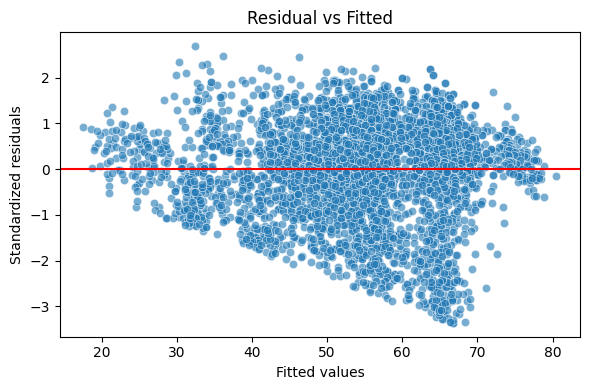

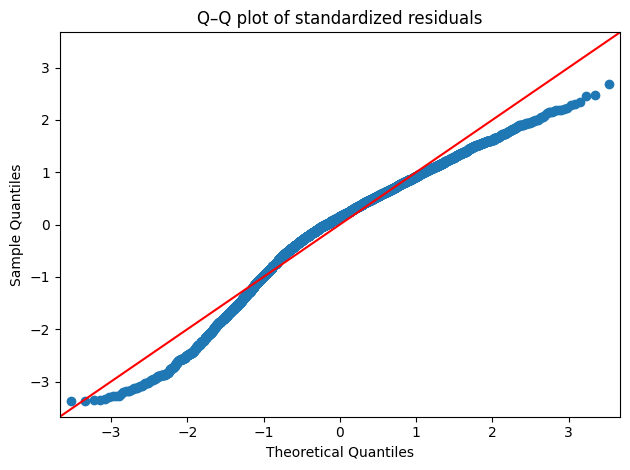

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# 以 forward_model 為例
resid = forward_model.get_influence().resid_studentized_internal
fitted = forward_model.fittedvalues

# 殘差 vs 預測值
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residual vs Fitted")
plt.tight_layout()
plt.show()

# Q-Q plot
sm.qqplot(resid, line='45', fit=True)
plt.title("Q–Q plot of standardized residuals")
plt.tight_layout()
plt.show()



📊 正態性檢定
Shapiro-Wilk test: W = 0.9630, p = 0.0000
❌ Reject H0 → 殘差不符合常態性


<Figure size 600x600 with 0 Axes>

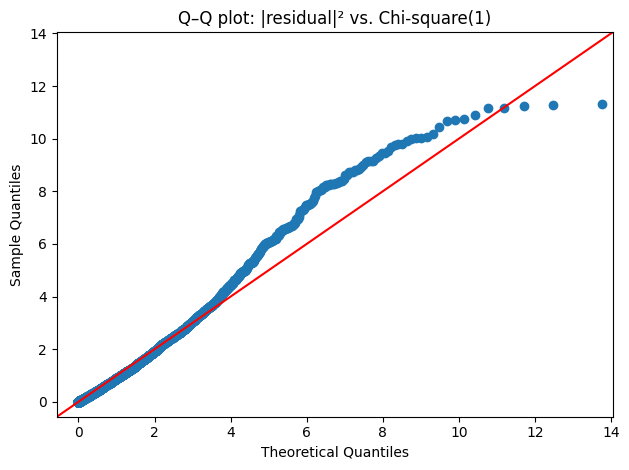


📊 異質變異檢定（目視）


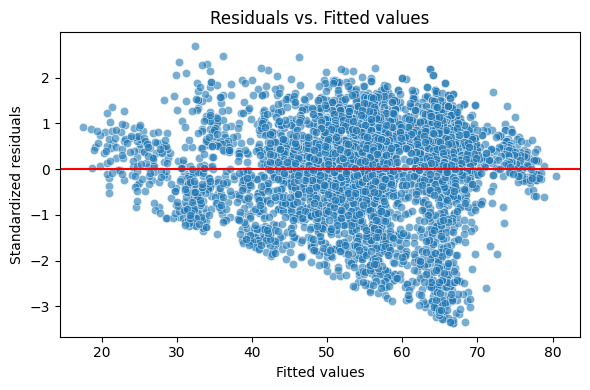

✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）

📊 獨立性檢定（Runs Test）
Runs Test: stat = -41.4269, p = 0.0000
❌ Reject H0 → 殘差可能不獨立


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.sandbox.stats.runs import runstest_1samp

# 1. 取出殘差與預測值
resid = forward_model.get_influence().resid_studentized_internal
fitted = forward_model.fittedvalues

# -----------------------------------------------------
# (a) 常態性檢定
print("\n📊 正態性檢定")

# 1.1 Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(resid)
print(f"Shapiro-Wilk test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("✅ Do not reject H0 → 殘差符合常態性")
else:
    print("❌ Reject H0 → 殘差不符合常態性")

# 1.2 Chi-square Q–Q plot
plt.figure(figsize=(6, 6))
abs_resid_squared = np.square(np.abs(resid))
sm.qqplot(abs_resid_squared, dist=stats.chi2, distargs=(1,), line='45')
plt.title("Q–Q plot: |residual|² vs. Chi-square(1)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# (b) 等變異性檢定（homoscedasticity）
print("\n📊 異質變異檢定（目視）")

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residuals vs. Fitted values")
plt.tight_layout()
plt.show()
print("✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）")

# -----------------------------------------------------
# (c) 獨立性檢定（runs test）
print("\n📊 獨立性檢定（Runs Test）")

runs_stat, runs_p = runstest_1samp(resid, cutoff='mean')
print(f"Runs Test: stat = {runs_stat:.4f}, p = {runs_p:.4f}")
if runs_p > 0.05:
    print("✅ Do not reject H0 → 殘差獨立")
else:
    print("❌ Reject H0 → 殘差可能不獨立")


### 5-2 Backward Regression

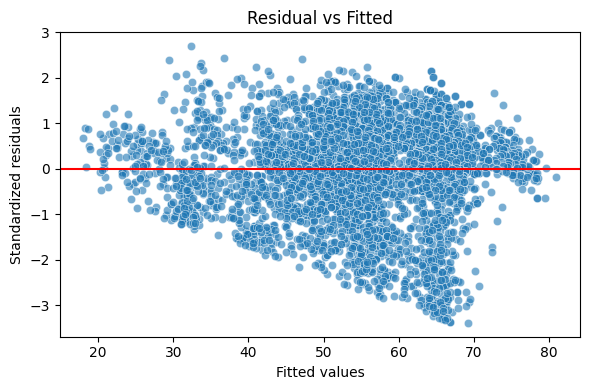

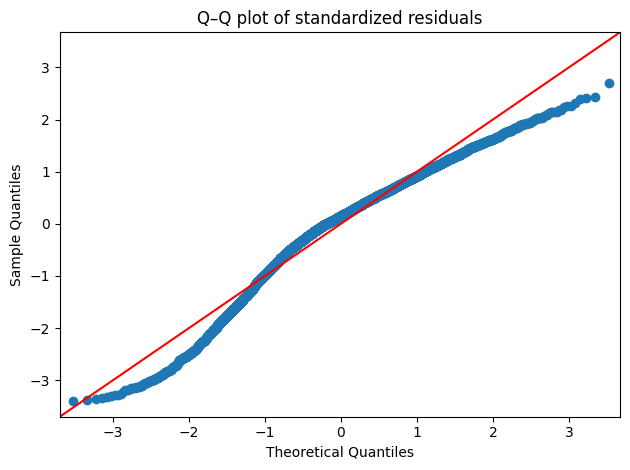

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# 以 backward_model 為例
resid = backward_model.get_influence().resid_studentized_internal
fitted = backward_model.fittedvalues

# 殘差 vs 預測值
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residual vs Fitted")
plt.tight_layout()
plt.show()

# Q-Q plot
sm.qqplot(resid, line='45', fit=True)
plt.title("Q–Q plot of standardized residuals")
plt.tight_layout()
plt.show()



📊 正態性檢定
Shapiro-Wilk test: W = 0.9628, p = 0.0000
❌ Reject H0 → 殘差不符合常態性


<Figure size 600x600 with 0 Axes>

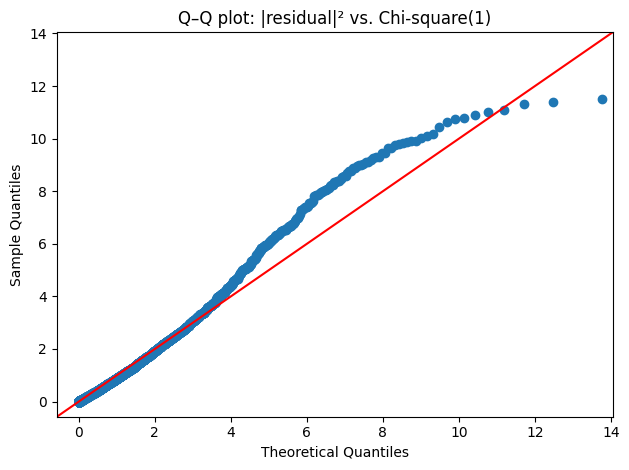


📊 異質變異檢定（目視）


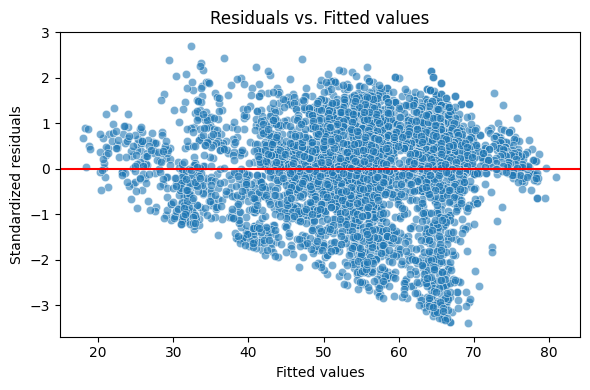

✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）

📊 獨立性檢定（Runs Test）
Runs Test: stat = -41.8681, p = 0.0000
❌ Reject H0 → 殘差可能不獨立


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.sandbox.stats.runs import runstest_1samp

# 1. 取出殘差與預測值
resid = backward_model.get_influence().resid_studentized_internal
fitted = backward_model.fittedvalues

# -----------------------------------------------------
# (a) 常態性檢定
print("\n📊 正態性檢定")

# 1.1 Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(resid)
print(f"Shapiro-Wilk test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("✅ Do not reject H0 → 殘差符合常態性")
else:
    print("❌ Reject H0 → 殘差不符合常態性")

# 1.2 Chi-square Q–Q plot
plt.figure(figsize=(6, 6))
abs_resid_squared = np.square(np.abs(resid))
sm.qqplot(abs_resid_squared, dist=stats.chi2, distargs=(1,), line='45')
plt.title("Q–Q plot: |residual|² vs. Chi-square(1)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# (b) 等變異性檢定（homoscedasticity）
print("\n📊 異質變異檢定（目視）")

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=resid, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.title("Residuals vs. Fitted values")
plt.tight_layout()
plt.show()
print("✅ 若殘差無明顯扇形、漏斗狀，即可認為變異數為常數（homoscedasticity）")

# -----------------------------------------------------
# (c) 獨立性檢定（runs test）
print("\n📊 獨立性檢定（Runs Test）")

runs_stat, runs_p = runstest_1samp(resid, cutoff='mean')
print(f"Runs Test: stat = {runs_stat:.4f}, p = {runs_p:.4f}")
if runs_p > 0.05:
    print("✅ Do not reject H0 → 殘差獨立")
else:
    print("❌ Reject H0 → 殘差可能不獨立")


# 6 歷史紀錄

初步 OLS 回歸模型分析（舊版，直接drop_cols）



In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors], genre_dummies], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     45.90
Date:                Tue, 10 Jun 2025   Prob (F-statistic):               0.00
Time:                        07:04:02   Log-Likelihood:                -20398.
No. Observations:                4830   AIC:                         4.089e+04
Df Residuals:                    4783   BIC:                         4.120e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

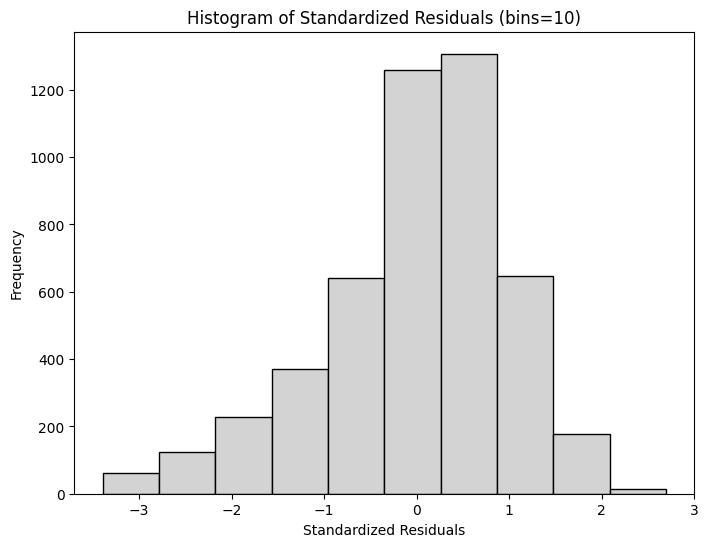

In [ ]:
import matplotlib.pyplot as plt

# 計算標準化殘差
influence = result.get_influence()
std_resid = influence.resid_studentized_internal

# 畫直方圖
plt.figure(figsize=(8, 6))
plt.hist(std_resid, bins=10, facecolor='lightgrey', edgecolor='black')
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Standardized Residuals (bins=10)')
plt.show()


## Backward Stepwise Regression
### 應變數為 track_popularity


In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

# print(data.shape)
# display(data['genre_ambient'].value_counts())
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

liveness is removed with p-value 0.9714.

genre_soul is removed with p-value 0.8937.

genre_mandopop is removed with p-value 0.7334.

genre_lofi is removed with p-value 0.7634.

genre_ambient is removed with p-value 0.6624.

duration_ms is removed with p-value 0.6585.

mode is removed with p-value 0.5505.

acousticness is removed with p-value 0.4246.

genre_latin is removed with p-value 0.3427.

genre_reggae is removed with p-value 0.3427.

genre_country is removed with p-value 0.2861.

tempo is removed with p-value 0.2366.

energy is removed with p-value 0.1674.

genre_jazz is removed with p-value 0.1677.

genre_electronic is removed with p-value 0.0753.

genre_indie is removed with p-value 0.0577.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.300
Method:                

### 🔍 殘差圖觀察重點
#### ✅ 水平橘線是殘差平均線（0）
正常情況下，點應大致分布在橘線上下，無明顯形狀。

#### ❌ 圖中問題
漏斗形（右側較窄）：

表示 異質變異（heteroscedasticity），預測值越大時殘差變異越小，這違反了迴歸分析的基本假設（殘差變異應該一致）。

意味著模型對於不同預測值的解釋力不一致，可能在中低預測值時失準。

非隨機分布：

正常的殘差圖應呈現無規律的雲狀分布，但這張圖呈現某種錐形，可能代表模型形式錯誤（例如少了非線性項）。

Text(0, 0.5, 'Standardized Residuals of track popularity')

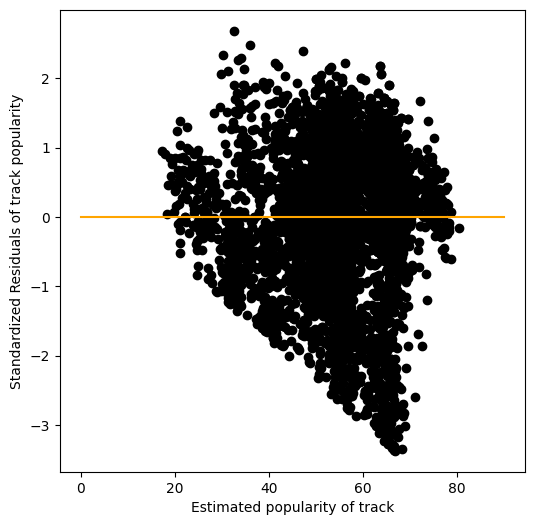

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

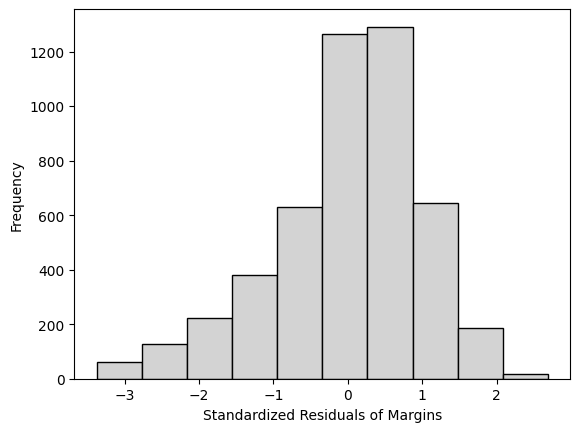

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

3.147856815344811e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -41.8393
p-value: 0.0000


## 三個交互作用項
這裡我們建立了三個交互作用項：

- `danceability_tempo`：舞蹈性 × 節奏（danceability × tempo），反映歌曲的舞蹈感與節奏快慢的綜合效果。
- `danceability_energy`：舞蹈性 × 能量（danceability × energy），結合舞蹈感與能量感，捕捉兩者同時高或低時的影響。
- `energy_valence`：能量 × 愉悅度（energy × valence），用來觀察高能量且愉悅的歌曲是否特別受歡迎。

這些交互作用項有助於模型捕捉變數間非線性的聯合效果，提升預測能力。

In [ ]:
# 先建立交互作用項
data_interact = data.copy()
# 1. danceability × tempo
data_interact['danceability_tempo'] = data_interact['danceability'] * data_interact['tempo']
# 2. danceability × energy
data_interact['danceability_energy'] = data_interact['danceability'] * data_interact['energy']
# 3. energy × valence
data_interact['energy_valence'] = data_interact['energy'] * data_interact['valence']

# 準備 response
response = 'track_popularity'

# 將所有 predictor（原本的 + 交互作用項）組合
predictors_interact = [col for col in data_interact.columns if col != response]

# 執行 backward selection
result_interact = backward_selection(data_interact[predictors_interact + [response]], response=response)
print(result_interact.summary())

liveness is removed with p-value 0.9624.

genre_soul is removed with p-value 0.8417.

genre_mandopop is removed with p-value 0.7422.

genre_ambient is removed with p-value 0.7773.

genre_lofi is removed with p-value 0.6791.

duration_ms is removed with p-value 0.6026.

mode is removed with p-value 0.4990.

genre_latin is removed with p-value 0.4078.

genre_reggae is removed with p-value 0.3707.

genre_country is removed with p-value 0.3557.

danceability_tempo is removed with p-value 0.3267.

acousticness is removed with p-value 0.2532.

energy_valence is removed with p-value 0.2474.

genre_jazz is removed with p-value 0.1813.

tempo is removed with p-value 0.1311.

genre_arabic is removed with p-value 0.0586.

genre_turkish is removed with p-value 0.0854.

genre_gospel is removed with p-value 0.0682.

valence is removed with p-value 0.0683.

danceability is removed with p-value 0.0540.

No variable is removed. Stop.
                            OLS Regression Results                   

Text(0, 0.5, 'Standardized Residuals of track popularity')

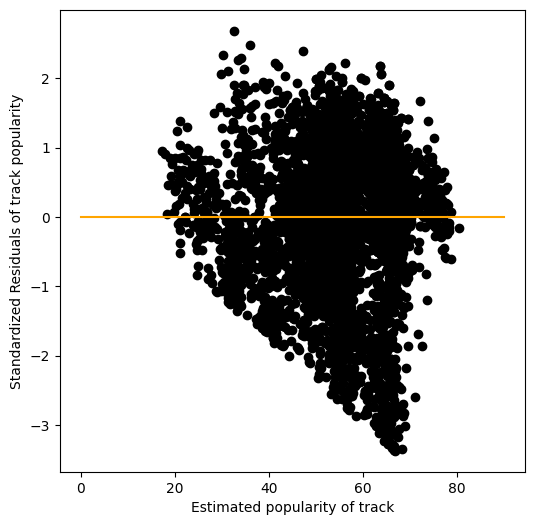

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

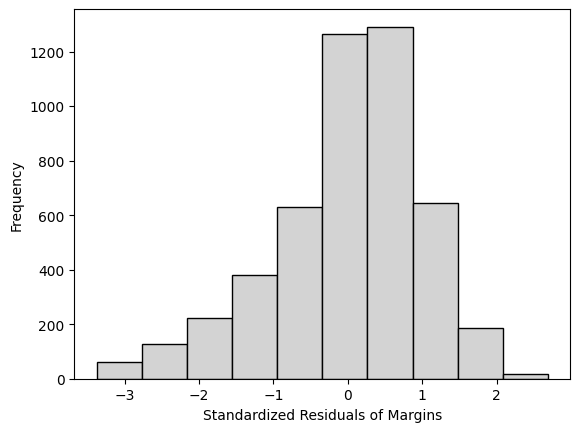

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

3.147856815344811e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -41.8393
p-value: 0.0000


## Backwards Stepwise Regression
### 應變數為 $ \log(\text{track\_popularity}) $

In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy

# 將 track_popularity 取 log（加 1 防止 log(0)）
df['track_popularity'] = np.log(df['track_popularity'])
predictors = [col for col in df.columns if col not in exclude_cols]


data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

# print(data.shape)
# display(data['genre_ambient'].value_counts())
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

genre_turkish is removed with p-value 0.9867.

genre_arabic is removed with p-value 0.9603.

liveness is removed with p-value 0.9158.

genre_gospel is removed with p-value 0.8633.

genre_country is removed with p-value 0.7872.

genre_latin is removed with p-value 0.6493.

mode is removed with p-value 0.3659.

genre_jazz is removed with p-value 0.3472.

tempo is removed with p-value 0.2499.

genre_mandopop is removed with p-value 0.2417.

duration_ms is removed with p-value 0.2172.

valence is removed with p-value 0.2273.

genre_soul is removed with p-value 0.2176.

genre_reggae is removed with p-value 0.1490.

acousticness is removed with p-value 0.1035.

energy is removed with p-value 0.1085.

genre_ambient is removed with p-value 0.0940.

speechiness is removed with p-value 0.0787.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.259
Model:          

Text(0, 0.5, 'Residuals of log(track popularity)')

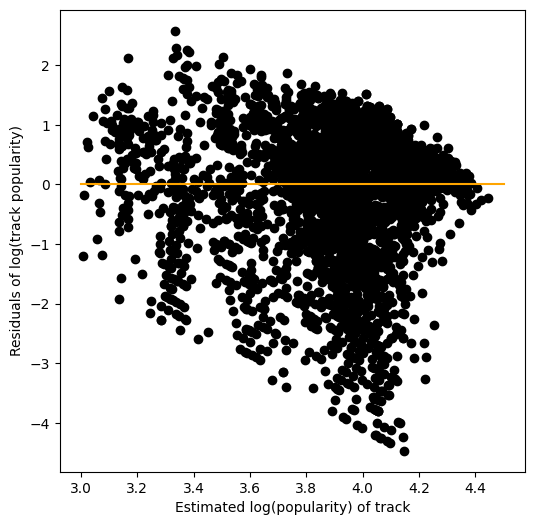

In [ ]:
influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([3, 4.5], [0, 0], color = 'orange')
plt.xlabel('Estimated log(popularity) of track')
plt.ylabel('Residuals of log(track popularity)')


Text(0, 0.5, 'Frequency')

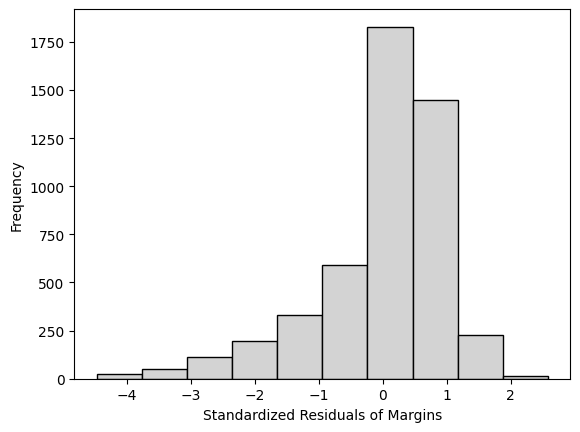

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

2.6682311789197867e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.8934
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -39.0126
p-value: 0.0000


## Genre Pop ols


In [ ]:

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'pop' ]  # 去除 track_popularity <= 0 的資料

exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     7.327
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.86e-12
Time:                        01:23:37   Log-Likelihood:                -2342.7
No. Observations:                 515   AIC:                             4711.
Df Residuals:                     502   BIC:                             4767.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           23.7547     14.016  

Text(0, 0.5, 'Standardized Residuals of track popularity')

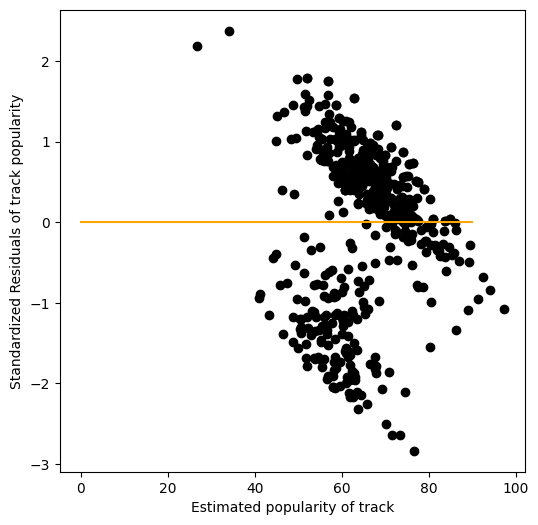

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

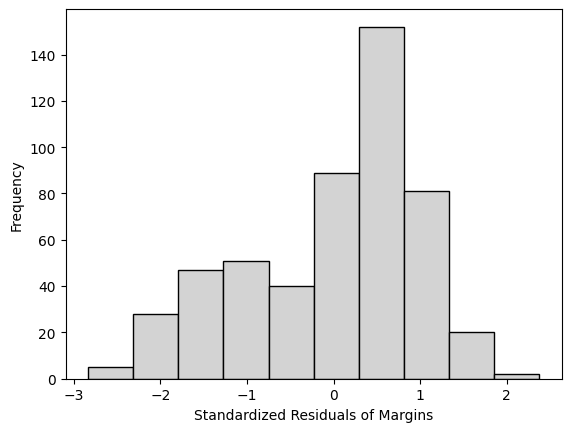

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.0006916619996732638

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9434
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -14.7655
p-value: 0.0000


## Backwards Stepwise Regression
### Genre Pop

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'pop' ]  # 去除 track_popularity <= 0 的資料


# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

liveness is removed with p-value 0.9074.

danceability is removed with p-value 0.8329.

tempo is removed with p-value 0.6245.

mode is removed with p-value 0.5666.

speechiness is removed with p-value 0.5220.

energy is removed with p-value 0.1524.

instrumentalness is removed with p-value 0.2232.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     16.76
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.44e-15
Time:                        01:23:37   Log-Likelihood:                -2345.0
No. Observations:                 515   AIC:                             4702.
Df Residuals:                     509   BIC:                             4728.
Df Model:                           5 

Text(0, 0.5, 'Standardized Residuals of track popularity')

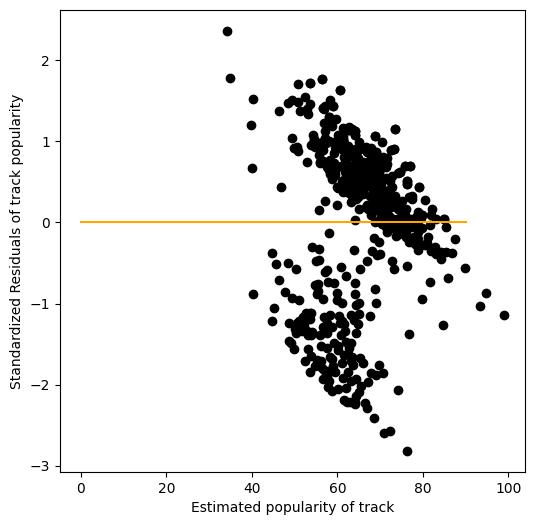

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

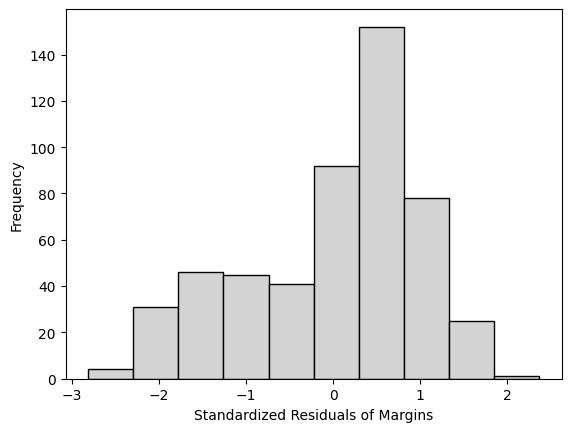

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.000474908705546643

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9397
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -14.7497
p-value: 0.0000


## Genre 的曲數 > 100 做 ols

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
# 篩選 playlist_genre 數量大於 30 的資料
genre_counts = df['playlist_genre'].value_counts()
df = df[df['playlist_genre'].isin(genre_counts[genre_counts > 100].index)]


print(df['playlist_genre'].value_counts())
genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True)

exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors], genre_dummies], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
electronic    589
pop           515
latin         425
hiphop        395
ambient       359
rock          345
lofi          299
world         228
arabic        208
brazilian     148
jazz          146
gaming        133
classical     121
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     64.65
Date:                Wed, 28 May 2025   Prob (F-statistic):          1.31e-261
Time:                        01:23:38   Log-Likelihood:                -16681.
No. Observations:                3910   AIC:                         3.341e+04
Df Residuals:                    3885   BIC:                         3.357e+04
Df Model:                          24                                         
Covariance Typ

Text(0, 0.5, 'Standardized Residuals of track popularity')

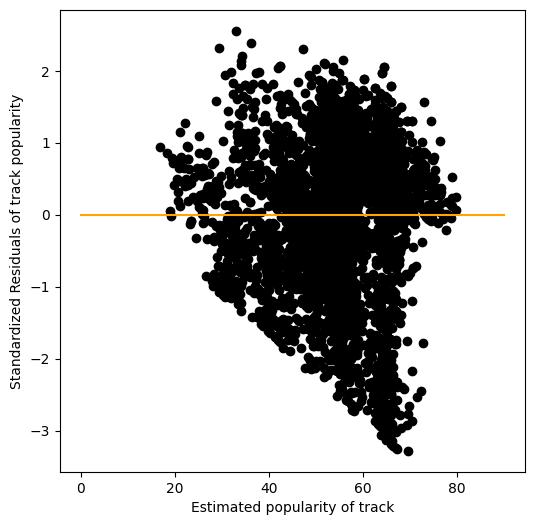

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

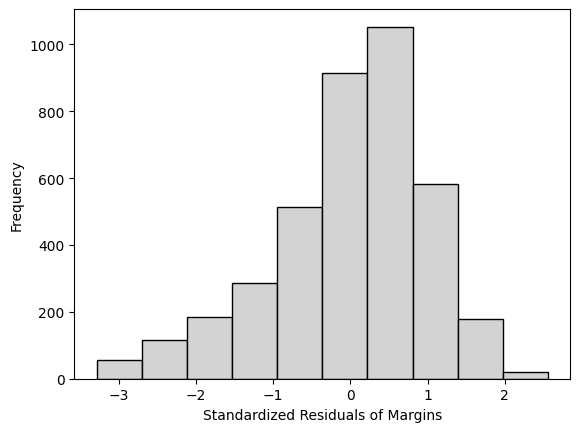

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

-2.4757540208839274e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9623
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -38.9829
p-value: 0.0000


## Backwards Stepwise Regression
### 應變數為 $ \text{track\_popularity} $

#### Genre 的曲數 > 100

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
# 篩選 playlist_genre 數量大於 100 的資料
genre_counts = df['playlist_genre'].value_counts()
df = df[df['playlist_genre'].isin(genre_counts[genre_counts > 100].index)]


print(df['playlist_genre'].value_counts())

genre_dummies = pd.get_dummies(df["playlist_genre"], prefix="genre", drop_first=True).astype(int)

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],
    genre_dummies[[col for col in genre_dummies.columns if col.startswith('genre_')]]
], axis=1)

result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
electronic    589
pop           515
latin         425
hiphop        395
ambient       359
rock          345
lofi          299
world         228
arabic        208
brazilian     148
jazz          146
gaming        133
classical     121
Name: count, dtype: int64
liveness is removed with p-value 0.8413.

genre_lofi is removed with p-value 0.8191.

mode is removed with p-value 0.6166.

genre_latin is removed with p-value 0.5988.

acousticness is removed with p-value 0.4259.

tempo is removed with p-value 0.2333.

energy is removed with p-value 0.1439.

genre_electronic is removed with p-value 0.2047.

loudness is removed with p-value 0.0840.

genre_jazz is removed with p-value 0.1002.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Leas

Text(0, 0.5, 'Standardized Residuals of track popularity')

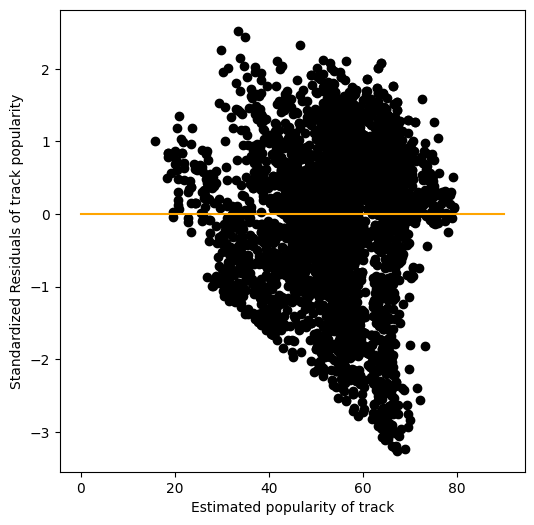

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

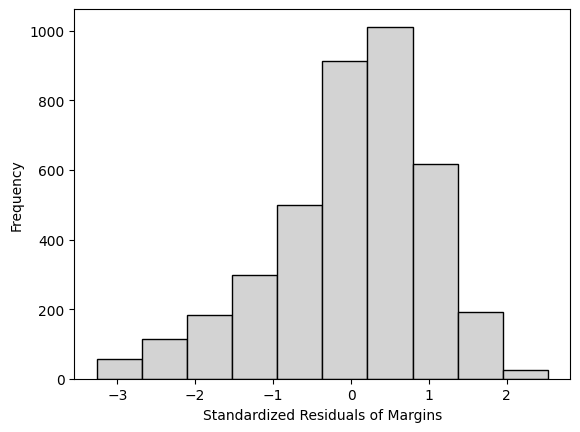

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

-3.323057807008232e-05

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9638
p-value: 0.0000


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -38.4478
p-value: 0.0000


## Genre Gaming


In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'gaming' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
gaming    133
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     20.61
Date:                Wed, 28 May 2025   Prob (F-statistic):           8.35e-24
Time:                        01:23:43   Log-Likelihood:                -502.42
No. Observations:                 133   AIC:                             1031.
Df Residuals:                     120   BIC:                             1068.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

Text(0, 0.5, 'Standardized Residuals of track popularity')

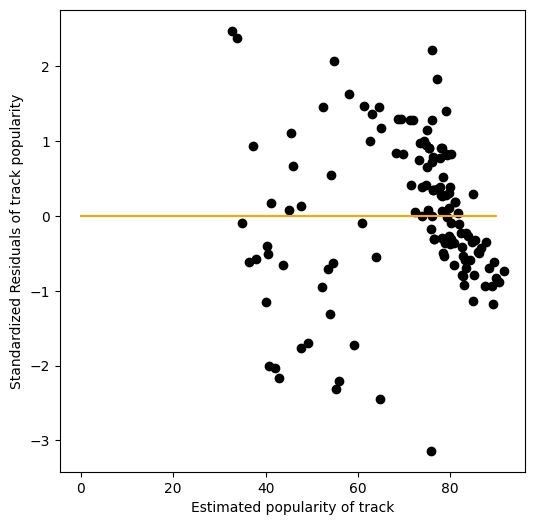

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

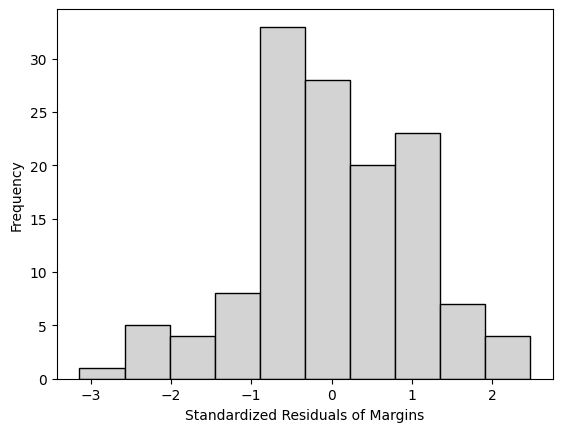

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.006573797435076452

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9852
p-value: 0.1590


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -3.5574
p-value: 0.0004


## Backwards Stepwise Regression
### Genre Gaming


In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'gaming' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
gaming    133
Name: count, dtype: int64
duration_ms is removed with p-value 0.9617.

speechiness is removed with p-value 0.9348.

energy is removed with p-value 0.8690.

mode is removed with p-value 0.8230.

key is removed with p-value 0.4682.

liveness is removed with p-value 0.4174.

valence is removed with p-value 0.3164.

acousticness is removed with p-value 0.3163.

loudness is removed with p-value 0.4040.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     84.53
Date:                Wed, 28 May 2025   Prob (F-statistic):           2.62e-30
Time:                        01:23:43   Log-Likelihood:                -504.53
No. Observations:                 133   AIC:                     

Text(0, 0.5, 'Standardized Residuals of track popularity')

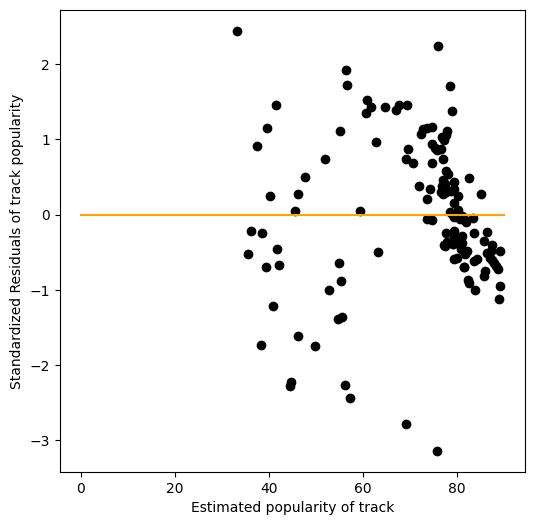

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

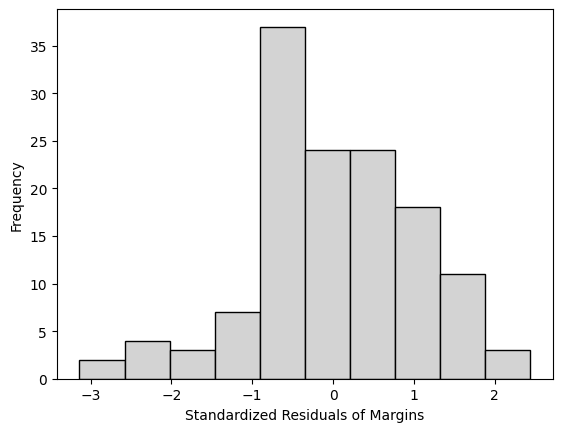

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')

### 四項殘差分析

#### The model: zero mean

In [ ]:
np.mean(standardized_residuals)

0.0016112702176818733

#### The model: homoscedasticity (equal variance)

### 自己看

#### The model: normality

In [ ]:
import scipy.stats as scipy_stats
# Shapiro test
statistic, p_value = scipy_stats.shapiro(standardized_residuals)

print(f"Shapiro test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Shapiro test statistic: 0.9796
p-value: 0.0429


#### The model: independent residuals

In [ ]:
# run test
from statsmodels.sandbox.stats.runs import runstest_1samp

z_stat, p_value = runstest_1samp(standardized_residuals, correction=True)

print(f"Runs test z statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

Runs test z statistic: -3.1974
p-value: 0.0014


### ROCK

In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'rock' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
rock    345
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.661
Date:                Wed, 28 May 2025   Prob (F-statistic):             0.0741
Time:                        01:27:11   Log-Likelihood:                -1421.5
No. Observations:                 345   AIC:                             2869.
Df Residuals:                     332   BIC:                             2919.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

### 後面來?

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'rock' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
rock    345
Name: count, dtype: int64
danceability is removed with p-value 0.7259.

duration_ms is removed with p-value 0.6218.

liveness is removed with p-value 0.4469.

instrumentalness is removed with p-value 0.3497.

speechiness is removed with p-value 0.3422.

acousticness is removed with p-value 0.2759.

tempo is removed with p-value 0.2225.

mode is removed with p-value 0.1342.

key is removed with p-value 0.1951.

energy is removed with p-value 0.1038.

loudness is removed with p-value 0.3696.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     7.113
Date:                Wed, 28 May 2025   Prob (F-statistic):            0.00802
Time:                        01:27:13   Log-Likeliho

### Hipop

In [ ]:
import statsmodels.formula.api as smf

df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'hiphop' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())
exclude_cols = ['track_popularity', 'playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]
df_model = pd.concat([df[predictors]], axis=1)

# 自動產生公式
formula = "track_popularity ~ " + " + ".join(df_model.columns)

# 建模
model = smf.ols(formula, data=pd.concat([df["track_popularity"], df_model], axis=1))
result = model.fit()

# 顯示結果
print(result.summary())

playlist_genre
hiphop    395
Name: count, dtype: int64
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     8.349
Date:                Wed, 28 May 2025   Prob (F-statistic):           4.70e-14
Time:                        01:27:15   Log-Likelihood:                -1646.1
No. Observations:                 395   AIC:                             3318.
Df Residuals:                     382   BIC:                             3370.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

### backward hipop

In [ ]:
df = pd.concat([high, low], ignore_index=True)
df['playlist_genre'] = df['playlist_genre'].replace('hip-hop', 'hiphop')
df['playlist_genre'] = df['playlist_genre'].replace('j-pop', 'jpop')
df['playlist_genre'] = df['playlist_genre'].replace('k-pop', 'kpop')
df['playlist_genre'] = df['playlist_genre'].replace('r&b', 'r8b')

drop_cols = ['track_artist', 'time_signature', 'track_href', 'uri', 'track_album_name', 'playlist_name', 'analysis_url', 'track_id', 'track_name', 'track_album_release_date', 'track_album_id', 'id', 'playlist_subgenre', 'type', 'playlist_id']

df = df.drop(columns=drop_cols)
df = df[df['playlist_genre'] ==  'hiphop' ]  # 去除 track_popularity <= 0 的資料

print(df['playlist_genre'].value_counts())

# 建立模型資料集，包含所有欄位（去除目標變數與 genre_dummies 重複欄位）
exclude_cols = ['playlist_genre']  # track_popularity 是目標變數，playlist_genre 已經 dummy
predictors = [col for col in df.columns if col not in exclude_cols]

data = pd.concat([
    df[predictors],

], axis=1)
result = backward_selection(data, response = 'track_popularity')
print(result.summary())

playlist_genre
hiphop    395
Name: count, dtype: int64
mode is removed with p-value 0.9771.

tempo is removed with p-value 0.8882.

danceability is removed with p-value 0.7968.

acousticness is removed with p-value 0.4265.

liveness is removed with p-value 0.1807.

key is removed with p-value 0.0581.

valence is removed with p-value 0.0662.

No variable is removed. Stop.
                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     18.03
Date:                Wed, 28 May 2025   Prob (F-statistic):           4.33e-16
Time:                        01:27:17   Log-Likelihood:                -1650.9
No. Observations:                 395   AIC:                             3314.
Df Residuals:                     389   BIC:                             

Text(0, 0.5, 'Standardized Residuals of track popularity')

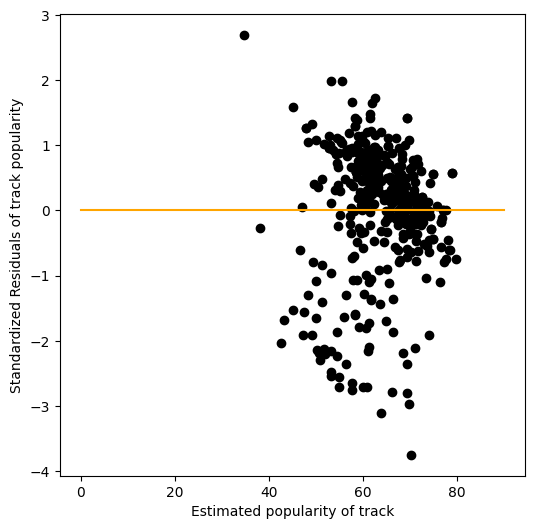

In [ ]:
import matplotlib.pyplot as plt

influence = result.get_influence()
residuals = result.resid
standardized_residuals = influence.resid_studentized_internal
estimated_values = result.fittedvalues
plt.figure(figsize = (6, 6))

plt.plot(estimated_values, standardized_residuals, 'o', color = 'black')
plt.plot([0, 90], [0, 0], color = 'orange')

plt.xlabel('Estimated popularity of track')
plt.ylabel('Standardized Residuals of track popularity')

Text(0, 0.5, 'Frequency')

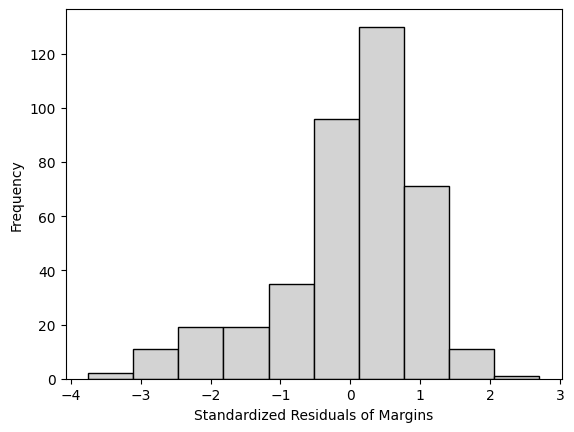

In [ ]:
plt.hist(standardized_residuals, facecolor = 'lightgrey', edgecolor = 'black')
plt.xlabel('Standardized Residuals of Margins')
plt.ylabel('Frequency')